# Linear regression with recursive feature elimination

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
import pickle
import os

This notebook shows how to train a linear regression model to create a forecast of future energy demand. In particular, the model will be trained to predict energy demand in period $t_{+1}$, one hour ahead of the current time period $t$. This is known as 'one-step' time series forecasting because we are predicting one period into the future.

In [1]:
model_name = "linear_regression"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']

In [4]:
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create design matrix - each column in this matrix represents a model feature and each row is a training example. We remove the *demand* and *timeStamp* variables as they are not model features.

In [5]:
X = train.drop(['demand', 'timeStamp'], axis=1)

### Create predictive model pipeline

Here we use sklearn's Pipeline functionality to create a predictive model pipeline. For this model, the pipeline implements the following steps:
- **one-hot encode categorical variables** - this creates a feature for each unique value of a categorical feature. For example, the feature *dayofweek* has 7 unique values. This feature is split into 7 individual features dayofweek0, dayofweek1, ... , dayofweek6. The value of these features is 1 if the timeStamp corresponds to that day of the week, otherwise it is 0.
- **recursive feature elimination with cross validation** - it is often the case that some features add little predictive power to a model and may even make the model accuracy worse. Recursive feature elimination tests the model accuracy on increasingly smaller subsets of the features to identify the subset which produces the most accurate model. Cross validation is used to test each subset on multiple folds of the input data. The best model is that which achieves the lowest mean squared error averaged across the cross validation folds.
- **train final model** - the best model found in after the feature elimination process is used to train the final estimator on the whole dataset.

Identify indices for categorical columns for one hot encoding and create the OneHotEncoder:

In [16]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)

Create the linear regression model object

In [7]:
regr = linear_model.LinearRegression(fit_intercept=True)

For hyperparameter tuning and feature selection, cross validation will be performed using the training set. With time series forecasting, it is important that test data comes from a later time period than the training data. This also applies to each fold in cross validation. Therefore a time series split is used to create three folds for cross validation as illustrated below. Each time series plot represents a separate training/test split, with the training set coloured in blue and the test set coloured in red. Note that, even in the first split, the training data covers at least a full year so that the model can learn the annual seasonality of the demand.

In [8]:
tscv = TimeSeriesSplit(n_splits=3)

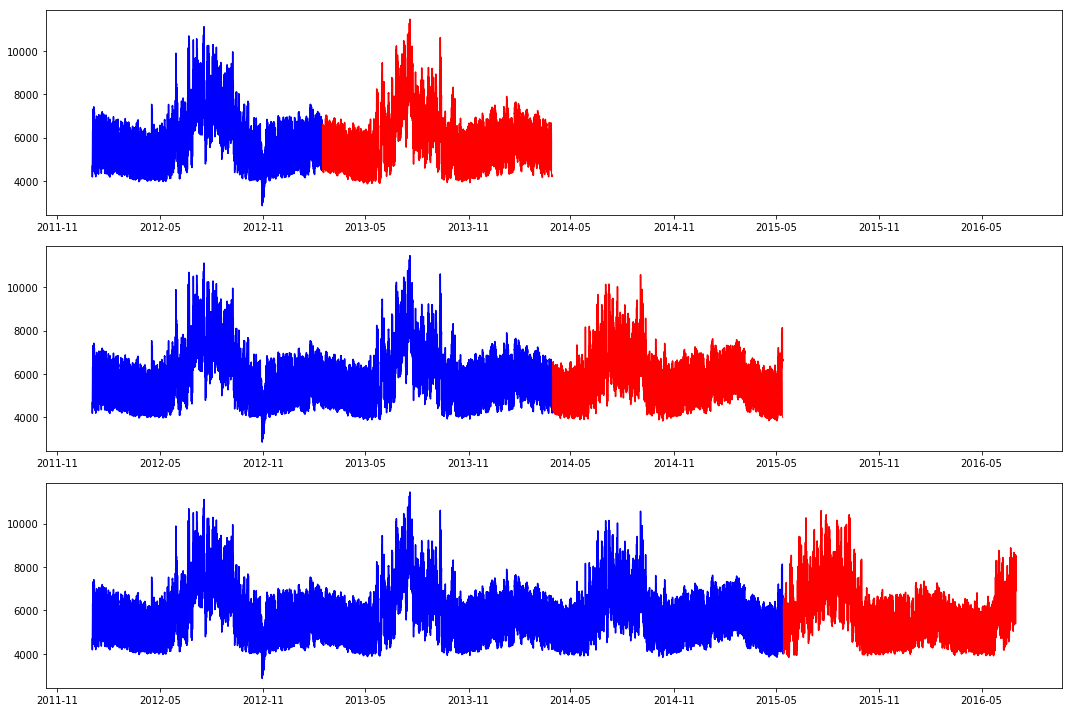

In [39]:
demand_ts = train[['timeStamp', 'demand']].copy()
demand_ts.reset_index(drop=True, inplace=True)

for split in enumerate(tscv.split(demand_ts)):
    split_num = str(split[0])
    train_idx = split[1][0]
    test_idx = split[1][1]
    demand_ts['fold' + split_num] = "not used"
    demand_ts.loc[train_idx, 'fold' + split_num] = "train"
    demand_ts.loc[test_idx, 'fold' + split_num] = "test"

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

ax = fig.add_subplot(gs[0])
ax.plot(demand_ts.loc[demand_ts['fold0']=="train", "timeStamp"], demand_ts.loc[demand_ts['fold0']=="train", "demand"], color='b')
ax.plot(demand_ts.loc[demand_ts['fold0']=="test", "timeStamp"], demand_ts.loc[demand_ts['fold0']=="test", "demand"], 'r')
ax.plot(demand_ts.loc[demand_ts['fold0']=="not used", "timeStamp"], demand_ts.loc[demand_ts['fold0']=="not used", "demand"], 'w')

ax = fig.add_subplot(gs[1], sharex=ax)
plt.plot(demand_ts.loc[demand_ts['fold1']=="train", "timeStamp"], demand_ts.loc[demand_ts['fold1']=="train", "demand"], 'b')
plt.plot(demand_ts.loc[demand_ts['fold1']=="test", "timeStamp"], demand_ts.loc[demand_ts['fold1']=="test", "demand"], 'r')
plt.plot(demand_ts.loc[demand_ts['fold1']=="not used", "timeStamp"], demand_ts.loc[demand_ts['fold1']=="not used", "demand"], 'w')

ax = fig.add_subplot(gs[2], sharex=ax)
plt.plot(demand_ts.loc[demand_ts['fold2']=="train", "timeStamp"], demand_ts.loc[demand_ts['fold2']=="train", "demand"], 'b')
plt.plot(demand_ts.loc[demand_ts['fold2']=="test", "timeStamp"], demand_ts.loc[demand_ts['fold2']=="test", "demand"], 'r')
plt.plot(demand_ts.loc[demand_ts['fold2']=="not used", "timeStamp"], demand_ts.loc[demand_ts['fold2']=="not used", "demand"], 'w')
plt.show()

Create the RFECV object. Note the metric for evaluating the model on each fold is the negative mean squared error. The best model is that which maximises this metric.

In [14]:
regr_cv = RFECV(estimator=regr,
             cv=tscv,
             scoring='neg_mean_squared_error',
             verbose=2,
             n_jobs=-1)

Create the model pipeline object.

In [17]:
regr_pipe = Pipeline([('onehot', onehot), ('rfecv', regr_cv)])

Train the model pipeline. This should take less than a minute.

In [18]:
regr_pipe.fit(X, y=train['demand'])

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('rfecv', RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=-1, scoring='neg_mean_squared_error', step=1, verbose=2))])

Save the trained model pipeline object.

In [20]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

Best CV negative mean squared error

In [22]:
max(regr_pipe.named_steps['rfecv'].grid_scores_)

-3604.9579444850519

Plot the cross validation errors with each subset of features. The chart shows that all features are useful to the model. However, the error gets significantly worse when there are 43 features or less in the model.

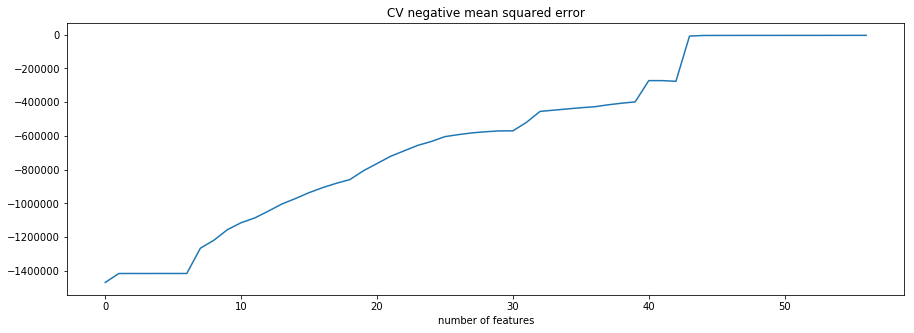

In [27]:
cv_results = pd.DataFrame.from_dict({'cv_score': regr_pipe.named_steps['rfecv'].grid_scores_})
cv_results['mean_squared_error'] = cv_results['cv_score']
plt.figure(figsize=(15, 5))
plt.plot(cv_results.index, cv_results['mean_squared_error'])
plt.xlabel('number of features')
plt.title('CV negative mean squared error')
plt.show()

Number of features selected

In [28]:
regr_pipe.named_steps['rfecv'].n_features_

57

Identify supported features after selection process

In [35]:
def get_onehot_cols(X):
    X_dummy_cols = list(pd.get_dummies(X.copy()[cat_cols], columns=cat_cols).columns)
    other_cols = list(X.columns.drop(cat_cols))
    return X_dummy_cols + other_cols
supported_features = pd.DataFrame.from_dict({'feature':get_onehot_cols(X),
                               'supported':regr_pipe.named_steps['rfecv'].support_})
supported_features

,feature,supported
0,hour_0,True
1,hour_1,True
2,hour_2,True
3,hour_3,True
4,hour_4,True
5,hour_5,True
6,hour_6,True
7,hour_7,True
8,hour_8,True
9,hour_9,True


Inspect model coefficients for each included feature. The magnitude and direction of the coefficients indicates the effect the features has on the model

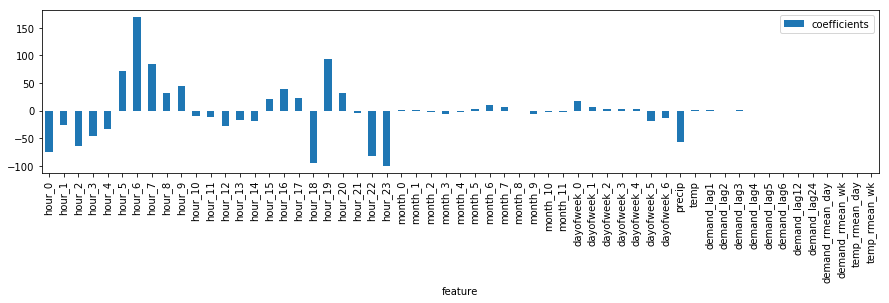

In [36]:
coefs = supported_features.loc[supported_features['supported'], ].copy()
coefs['coefficients'] = regr_pipe.named_steps['rfecv'].estimator_.coef_
coefs.plot.bar('feature', 'coefficients', figsize=(15, 3))
plt.show()